# Creating a Surrogate Model
This tutorial is based on the ['Peronne et al. (2018)' example](https://openml.github.io/openml-python/master/examples/40_paper/2018_neurips_perrone_example.html#sphx-glr-examples-40-paper-2018-neurips-perrone-example-py), but has  modifications to keep it brief.

In [1]:
import openml
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

## Downloading Experiment Data
In this notebook we create a surrogate model which predicts the AUC of a trained SVM on the Breast Cancer Wisconsin dataset, given the hyperparameter configuration of the SVM. First we download evaluations from OpenML of SVMs on the dataset:

In [2]:
evaluations = openml.evaluations.list_evaluations_setups(
     function='area_under_roc_curve',
     task=[145878],
     flow=[5891],
     uploader=[2702],
     output_format='dataframe',
     parameters_in_separate_columns=True
)
evaluations.head()

,run_id,task_id,setup_id,flow_id,flow_name,data_id,data_name,function,upload_time,uploader,...,value,values,array_data,mlr.classif.svm(7)_cost,mlr.classif.svm(7)_kernel,mlr.classif.svm(7)_degree,mlr.classif.svm(7)_openml.seed,mlr.classif.svm(7)_openml.kind,mlr.classif.svm(7)_openml.normal.kind,mlr.classif.svm(7)_gamma
0,2186880,145878,300625,5891,mlr.classif.svm(7),1510,wdbc,area_under_roc_curve,2017-05-17 01:01:22,2702,...,0.906896,None,"[0.906896,0.906896]",5.70749295459625,polynomial,2,1,Mersenne-Twister,Inversion,NaN
1,2186882,145878,300627,5891,mlr.classif.svm(7),1510,wdbc,area_under_roc_curve,2017-05-17 01:01:51,2702,...,0.925143,None,"[0.925143,0.925143]",646.27472639518,NaN,NaN,1,Mersenne-Twister,Inversion,0.87061319511489
2,2186883,145878,300628,5891,mlr.classif.svm(7),1510,wdbc,area_under_roc_curve,2017-05-17 01:01:56,2702,...,0.984792,None,"[0.984792,0.984792]",1.78584304520995,NaN,NaN,1,Mersenne-Twister,Inversion,0.18626527925297
3,2186884,145878,300629,5891,mlr.classif.svm(7),1510,wdbc,area_under_roc_curve,2017-05-17 01:02:02,2702,...,0.984554,None,"[0.984554,0.984554]",0.00950674702482963,NaN,NaN,1,Mersenne-Twister,Inversion,0.0163139827387585
4,2186885,145878,300630,5891,mlr.classif.svm(7),1510,wdbc,area_under_roc_curve,2017-05-17 01:02:04,2702,...,0.980273,None,"[0.980273,0.980273]",617.534395017289,linear,NaN,1,Mersenne-Twister,Inversion,NaN


## Preparing to train a surrogate model

For this application, we are only interested in the SVMs hyperparameters and their AUC scores. In this example, we restrict ourselves to four of the SVM hyperparameters: cost, degree, gamma and kernel.

In [3]:
evaluations.columns = [column.split('_')[-1] for column in evaluations.columns]
hyperparameters = ['cost', 'degree', 'gamma', 'kernel']
x, y = evaluations.loc[:, hyperparameters], evaluations.loc[:, 'value']
x.head()

,cost,degree,gamma,kernel
0,5.70749295459625,2,NaN,polynomial
1,646.27472639518,NaN,0.87061319511489,NaN
2,1.78584304520995,NaN,0.18626527925297,NaN
3,0.00950674702482963,NaN,0.0163139827387585,NaN
4,617.534395017289,NaN,NaN,linear


In [4]:
y.head()

0    0.906896
1    0.925143
2    0.984792
3    0.984554
4    0.980273
Name: value, dtype: float64

As we saw, the hyperparameter data has some missing values and categorical data (i.e. kernel column).
We are going to use scikit-learn's RandomForestRegressor to train a surrogate model, which does not allow for non-numeric data or missing values. To that end, we need to sanitize the input first.
We will encode the kernel column with one-hot encoding, and impute missing values.

In [5]:
# Separating data into categorical and non-categorical (numeric for this example) columns
cat_cols = ['kernel']
num_cols = list(set(hyperparameters) - set(cat_cols))

# Missing value imputers
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='None')
num_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)

# Creating the one-hot encoder
enc = OneHotEncoder(handle_unknown='ignore')

# Pipeline to handle categorical column transformations
cat_transforms = Pipeline(steps=[('impute', cat_imputer), ('encode', enc)])

# Combining column transformers
ct = ColumnTransformer([('cat', cat_transforms, cat_cols), ('num', num_imputer, num_cols)])

# Creating the full pipeline with the surrogate model
clf = RandomForestRegressor(n_estimators=50)
model = Pipeline(steps=[('preprocess', ct), ('surrogate', clf)])

## Training and using the surrogate model

With our pipeline sanitizing the input, we can train the full pipeline (and calculate training RMSE):

In [6]:
model.fit(x, y)
y_pred = model.predict(x)

print("Training RMSE : {:.5}".format(mean_squared_error(y, y_pred)))

Training RMSE : 1.814e-05


We will now use this surrogate model to find the regret of applying Random Search for this task.
We sample 10000 hyperparameter configurations and predict their performance with our surrogate model.

Text(0, 0.5, 'AUC')

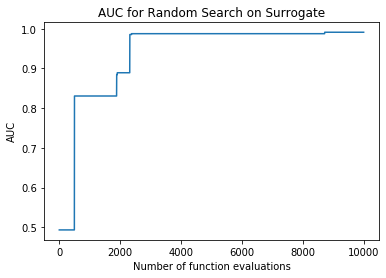

In [7]:
for i in range(1):
    num_samples = 10000
    ranges = [(0.000986, 998.492437),  # cost
              (2.0, 5.0),  # degree
              (0.000988, 913.373845),  # gamma
              (['linear', 'polynomial', 'radial', 'sigmoid'])]  # kernel
    X = pd.DataFrame(np.nan, index=range(num_samples), columns=hyperparameters)
    for i, range_ in enumerate(ranges):
        if len(range_) == 2:
            col_val = np.random.uniform(low=range_[0], high=range_[1], size=num_samples)
        else:
            col_val = np.random.choice(range_, size=num_samples)
        X.iloc[:, i] = col_val

    preds = model.predict(X)

    # tracking the maximum AUC obtained over the functions evaluations
    best_so_far_auc = np.maximum.accumulate(preds)

    # plotting the regret curve
    plt.plot(best_so_far_auc)


plt.title('AUC for Random Search on Surrogate')
plt.xlabel('Number of function evaluations')
plt.ylabel('AUC')

Of course there's much more to do here. Create a better aggregate plot for multiple generated random search results or evaluate the surrogate model on unseen data!

This concludes our look at the `openml-python` API. 
If you're interested in learning more about the package, visit the [documentation](https://openml.github.io/openml-python/master/).
If you need help or find bugs visit our Github repository at [OpenML/openml-python](https://github.com/openml/openml-python).

---
Code in this notebook is in part taken from openml-python under the BSD-3-Clause license, see `Talks\odsc\LICENSE`.